# DataSet

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x + 0.5 * torch.randn_like(x)),  # Add noise
    transforms.Lambda(lambda x: torch.clip(x, 0., 1.))           # Clip to valid range
])

clean_transform = transforms.ToTensor()

train_dataset_noisy = datasets.MNIST(root='.', train=True, download=True, transform=transform)
train_dataset_clean = datasets.MNIST(root='.', train=True, download=True, transform=clean_transform)
train_data_noisy = [img[0] for img in train_dataset_noisy]
train_data_clean = [img[0] for img in train_dataset_clean]


In [28]:
train_loader = DataLoader(list(zip(train_data_noisy, train_data_clean)), batch_size=128, shuffle=True)


In [29]:
print(train_data_noisy[0])

tensor([[[8.8185e-01, 2.3631e-01, 6.0298e-01, 2.1235e-01, 4.3442e-01,
          2.4955e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 5.5597e-01,
          0.0000e+00, 2.6016e-01, 1.0000e+00, 0.0000e+00, 8.5200e-02,
          3.1058e-01, 0.0000e+00, 7.6153e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 2.8093e-01, 1.7816e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [4.2405e-01, 0.0000e+00, 1.3927e-01, 0.0000e+00, 0.0000e+00,
          2.2677e-01, 0.0000e+00, 8.0720e-01, 1.0671e-02, 0.0000e+00,
          0.0000e+00, 5.4619e-01, 0.0000e+00, 4.0099e-01, 0.0000e+00,
          5.3842e-01, 0.0000e+00, 4.4591e-01, 9.9939e-01, 0.0000e+00,
          8.0071e-01, 0.0000e+00, 0.0000e+00, 3.7587e-02, 0.0000e+00,
          0.0000e+00, 1.6117e-01, 7.7713e-01],
         [0.0000e+00, 0.0000e+00, 6.0962e-02, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 6.0656e-01, 0.0000e+00, 1.8087e-01, 1.8548e-01,
          0.0000e+00, 0.0000e+00, 4.2185e-01, 4.6600e-01, 3.6342e-

In [30]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1,16,3,2,1),
            nn.ReLU(),
            nn.Conv2d(16,32,3,2,1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32,16,3,2,1,1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,1,3,2,1,1)
        )
    def forward(self,x):
            x = self.encoder(x)
            x = self.decoder(x)
            return x 

In [31]:
model = AutoEncoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [34]:
model.train()
for epoch in range(10):
    epoch_loss = 0 
    for (noisy,clean) in train_loader:
        optimizer.zero_grad()
        output = model(noisy)
        loss = criterion(output,clean)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.0149
Epoch 2, Loss: 0.0148
Epoch 3, Loss: 0.0147
Epoch 4, Loss: 0.0146
Epoch 5, Loss: 0.0145
Epoch 6, Loss: 0.0144
Epoch 7, Loss: 0.0143
Epoch 8, Loss: 0.0142
Epoch 9, Loss: 0.0142
Epoch 10, Loss: 0.0141


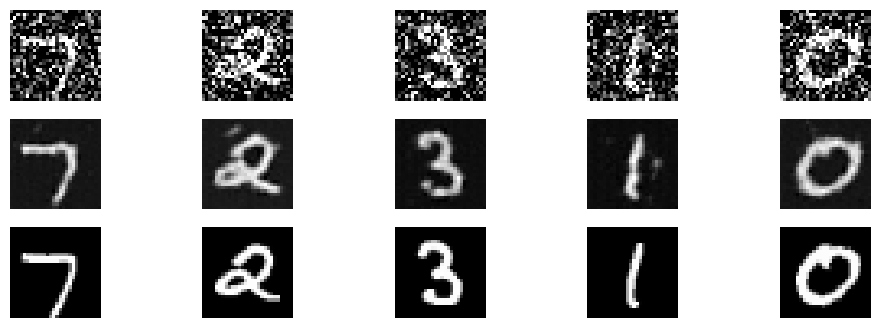

In [35]:
def show_images(noisy_imgs, denoised_imgs, clean_imgs, n=5):
    noisy_imgs = noisy_imgs.cpu().detach().numpy()
    denoised_imgs = denoised_imgs.cpu().detach().numpy()
    clean_imgs = clean_imgs.cpu().detach().numpy()
    
    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Noisy
        plt.subplot(3, n, i + 1)
        plt.imshow(noisy_imgs[i][0], cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel('Noisy')

        # Denoised
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(denoised_imgs[i][0], cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel('Denoised')

        # Original
        plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(clean_imgs[i][0], cmap='gray')
        plt.axis('off')
        if i == 0: plt.ylabel('Clean')
    plt.show()

# Get a batch and test
noisy_batch, clean_batch = next(iter(train_loader))
noisy_imgs = noisy_batch
clean_imgs = clean_batch
with torch.no_grad():
    denoised_imgs = model(noisy_imgs)
show_images(noisy_imgs, denoised_imgs, clean_imgs)
